In [1]:
import numpy as np
import pandas as pd
import os
import re
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import difflib
from collections import Counter

sys.path.append('/home/thabib/database_records_linkage')

#from metaphone import doublemetaphone
import recordlinkage
from preprocessing.pandas_oper import clean_columns

ROOT = '/home/thabib/database_records_linkage'

# 1. Exploratory Data Analysis

In [121]:
source1 = pd.read_csv(os.path.join(ROOT, 'data', 'source1.csv'))
source2 = pd.read_csv(os.path.join(ROOT, 'data', 'source2.csv'))
display(source1) # 1826169 rows in source 1 with all unique IDs
display(source2) # 3530302 rows in source2 with 1258224 NaN IDs – pd.isna(source2['id']).sum()
                 # 3530302 - 1258224 = 2272078 rows with proper IDs (but with repetitions, see below)

,id,name,street_number,street_type,street_name,address_line2,postal_code,city
0,542012000015,SOCIETE DES SUCRERIES DU MARQUENTERRE,NaN,RUE,DE LA FONTAINE,NaN,80120,RUE
1,542012000031,SOCIETE DES SUCRERIES DU MARQUENTERRE,NaN,RTE,NATIONALE,NaN,62140,MARCONNELLE
2,545011900028,LE GRAND CAFE ET GASSENDI,NaN,NaN,SAINT CHRISTOPHE,ROUTE DE MARSEILLE,4000,DIGNE-LES-BAINS
3,552017600016,HERNAS CARTONNAGE,50.0,RUE,PASTEUR,NaN,80210,FEUQUIERES-EN-VIMEU
4,552017600032,HERNAS CARTONNAGE,NaN,NaN,ZONE DES HAYETTES,NaN,80210,CHEPY
...,...,...,...,...,...,...,...,...
1826164,90771119600010,BIONORMANDE,NaN,RUE,DE LA GRANDE FLANDRE,LOT 1 - 7 A,76270,NEUFCHATEL-EN-BRAY
1826165,90771120400012,AHELA BAT,18.0,RUE,SAINT CLEMENT,NaN,93200,SAINT-DENIS
1826166,90771121200015,DECO BATIMENT,7.0,RUE,AUGUSTE BLANQUI,NaN,93200,SAINT-DENIS
1826167,90760906900014,CHATEAUX MERVEILLES,15.0,RUE,DE MILAN,NaN,75009,PARIS 9


,address,website,id,name
0,"226 r Menthon, 01380 SAINT CYR SUR MENTHON",NaN,NaN,Sandrine Berny
1,"50 rte Bage, 01380 SAINT CYR SUR MENTHON",NaN,8.412263e+13,Sarl Landrix Frères
2,"120 r Menthon, 01380 SAINT CYR SUR MENTHON",NaN,7.913458e+13,Marion Kwasniewski
3,"Moulin 28 chem RUILLAT, 01380 SAINT CYR SUR ME...",NaN,NaN,CLAUDE FONDATION
4,"350 rte Loeze, 01380 SAINT CYR SUR MENTHON",NaN,4.341618e+13,Manigand Stéphane
...,...,...,...,...
3530297,NaN,NaN,8.497810e+13,Jacoby O
3530298,"quart Guardère, 83150 BANDOL",http://agence.carrefourlocation.fr,NaN,Carrefour Location
3530299,"5 r Jardins, 83150 BANDOL",http://aquabike-en-mer.com,7.951850e+13,Calvet Richard
3530300,"54 traverse Laboureur, 83150 BANDOL",http://dolcefarnientebandol.com,5.392586e+13,Dolce Far Niente


#### Removing all entries with NaN IDs from source2 and also removing all duplicate rows + cleaning the columns with string entries

In [122]:
s2_nond = source2.dropna(subset=['id']).drop_duplicates()
s2_nond_cstr = clean_columns(s2_nond, ['address', 'name'])
s1_cstr = clean_columns(source1, ['name', 'street_type', 'street_name', 'address_line2', 'city'])
display(s1_cstr)
display(s2_nond_cstr)

,id,name,street_number,street_type,street_name,address_line2,postal_code,city
0,542012000015,societe des sucreries du marquenterre,NaN,rue,de la fontaine,NaN,80120,rue
1,542012000031,societe des sucreries du marquenterre,NaN,rte,nationale,NaN,62140,marconnelle
2,545011900028,le grand cafe et gassendi,NaN,NaN,saint christophe,route de marseille,4000,digne les bains
3,552017600016,hernas cartonnage,50.0,rue,pasteur,NaN,80210,feuquieres en vimeu
4,552017600032,hernas cartonnage,NaN,NaN,zone des hayettes,NaN,80210,chepy
...,...,...,...,...,...,...,...,...
1826164,90771119600010,bionormande,NaN,rue,de la grande flandre,lot 1 7 a,76270,neufchatel en bray
1826165,90771120400012,ahela bat,18.0,rue,saint clement,NaN,93200,saint denis
1826166,90771121200015,deco batiment,7.0,rue,auguste blanqui,NaN,93200,saint denis
1826167,90760906900014,chateaux merveilles,15.0,rue,de milan,NaN,75009,paris 9


,address,website,id,name
1,50 rte bage 01380 saint cyr sur menthon,NaN,8.412263e+13,sarl landrix freres
2,120 r menthon 01380 saint cyr sur menthon,NaN,7.913458e+13,marion kwasniewski
4,350 rte loeze 01380 saint cyr sur menthon,NaN,4.341618e+13,manigand stephane
5,41 r centre 01380 saint cyr sur menthon,http://www.infirmiere-frederique-thevenard.fr,4.885464e+13,frederique thevenard
6,116 chem cochatieres 01380 saint cyr sur menthon,NaN,4.181119e+13,garnier xavier
...,...,...,...,...
3530296,2 av chateau 83150 bandol,NaN,3.013066e+13,carlot jean francois
3530297,NaN,NaN,8.497810e+13,jacoby o
3530299,5 r jardins 83150 bandol,http://aquabike-en-mer.com,7.951850e+13,calvet richard
3530300,54 traverse laboureur 83150 bandol,http://dolcefarnientebandol.com,5.392586e+13,dolce far niente


In [123]:
s2_nond_cstr = s2_nond_cstr.astype({'id': 'Int64'})

In [110]:
len(np.unique(s2_nond_cstr['id']))

2270350

__There are only 2270350 unique IDs in source2 and the remaining 1012 (=2271362 - 2270350) IDs must, therefore, be repititions__

   - _There are 1010 unique IDs that are repeated twice and 1 unique ID is repeated thrice._

In [133]:
s2nond_uids, s2nond_uids_counts = np.unique(np.array(s2_nond_cstr['id']), return_counts=True)
duplicates = s2nond_uids[s2nond_uids_counts > 1]
display(duplicates)
display(len(duplicates))

Counter(s2nond_uids_counts)

array([6480115200089, 7692068500039, 13002792300049, ..., 95750393100561,
       99785860000023, 99882350414085], dtype=object)

1011

Counter({1: 2269339, 2: 1010, 3: 1})

#### How many repeated rows are there in source2 with NAN IDs?

In [114]:
#s2_nod = s2.drop_duplicates()
s2_nanid = source2[~source2.isin(s2_nond_cstr)].dropna(how='all')#.drop_duplicates()
s2_nod_nanid = s2_nanid.drop_duplicates()

#del s2_nod
display(s2_nanid)
display(s2_nod_nanid)

,address,website,id,name
0,"226 r Menthon, 01380 SAINT CYR SUR MENTHON",NaN,NaN,Sandrine Berny
1,"50 rte Bage, 01380 SAINT CYR SUR MENTHON",NaN,NaN,Sarl Landrix Frères
2,"120 r Menthon, 01380 SAINT CYR SUR MENTHON",NaN,NaN,Marion Kwasniewski
3,"Moulin 28 chem RUILLAT, 01380 SAINT CYR SUR ME...",NaN,NaN,CLAUDE FONDATION
4,"350 rte Loeze, 01380 SAINT CYR SUR MENTHON",NaN,NaN,Manigand Stéphane
...,...,...,...,...
3530297,NaN,NaN,NaN,Jacoby O
3530298,"quart Guardère, 83150 BANDOL",http://agence.carrefourlocation.fr,NaN,Carrefour Location
3530299,"5 r Jardins, 83150 BANDOL",NaN,NaN,Calvet Richard
3530300,"54 traverse Laboureur, 83150 BANDOL",NaN,NaN,Dolce Far Niente


,address,website,id,name
0,"226 r Menthon, 01380 SAINT CYR SUR MENTHON",NaN,NaN,Sandrine Berny
1,"50 rte Bage, 01380 SAINT CYR SUR MENTHON",NaN,NaN,Sarl Landrix Frères
2,"120 r Menthon, 01380 SAINT CYR SUR MENTHON",NaN,NaN,Marion Kwasniewski
3,"Moulin 28 chem RUILLAT, 01380 SAINT CYR SUR ME...",NaN,NaN,CLAUDE FONDATION
4,"350 rte Loeze, 01380 SAINT CYR SUR MENTHON",NaN,NaN,Manigand Stéphane
...,...,...,...,...
3530297,NaN,NaN,NaN,Jacoby O
3530298,"quart Guardère, 83150 BANDOL",http://agence.carrefourlocation.fr,NaN,Carrefour Location
3530299,"5 r Jardins, 83150 BANDOL",NaN,NaN,Calvet Richard
3530300,"54 traverse Laboureur, 83150 BANDOL",NaN,NaN,Dolce Far Niente


#### Counting NANs in columns of source1 and 2

In [134]:
s1_cstr['city'].isnull().sum()

0

#### Counting full address (no NANs in any address field) in source1

In [135]:
s1_fulladdress = s1_cstr.dropna(subset=['street_number', 'street_type', 'street_name', 'address_line2'])
s1_fulladdress

,id,name,street_number,street_type,street_name,address_line2,postal_code,city
19,568014500017,promens montoir de bretagne sas,73.0,rue,henri gautier,la providence,44550,montoir de bretagne
29,572078400148,etablissements decayeux,1.0,imp,nicephore niepce,za charles de gaulle,93290,tremblay en france
30,572078400155,etablissements decayeux,7.0,rue,des sarcelles,zone industrielle,80100,abbeville
42,578096000109,societe immobiliere touristique et hoteliere d...,5.0,esp,francois andre,sur plage face hotel hermitage,44500,la baule escoublac
46,582037800031,entreprise demouselle,140.0,rue,du chateau d eau,zone industrielle,80100,abbeville
...,...,...,...,...,...,...,...,...
1826064,90771049500017,gipsy,10.0,rue,de trevise,10 12,75009,paris 9
1826065,90771050300018,meyyartist paris,76.0,av,des champs elysees,76 78,75008,paris 8
1826085,90771083400017,larc batisseur,15.0,av,fernand chatelain,batiment sunset porte 4,95610,eragny
1826150,90771098200014,lapoleone publishing,4.0,rue,galilee,4 6,75116,paris 16


## 1.1 EDA Summary

__For Source1__

1. Total rows = 1826169
2. Unique rows = 1826169
3. Rows with non-NAN IDs = 1826169
4. Rows with unique non-NAN IDs = 1826169


5. NANs in 'name' = 2
6. Full addresses (no NANs in any of the address fields) = 270690




__For Source2__
1. Total rows = 3530302
2. Unique rows = 3528618 
3. Rows with non-NAN IDs = 2272078 
4. Rows with NAN IDs = 1257964
5. Rows left after removing duplicate rows and NAN IDs = 2271362. 
6. Rows with unique non-NAN IDs = 2270350.
7. Number of rows with repetitions of IDs = 2271362-2270350 = 1012 _{1010 IDs repeating twice, 1 ID repeating thrice}_


(For s2_nond_cstr)

8. NANs in 'address' = 10448, with 754 common with source1 (on IDs)
9. NANs in 'name' = 6
10. NANs in 'website' = 1320267



__Source1 + Source2__

1. Number of (unique) IDs common to both = 780883
2. Hence, there are 1045286 rows in source1 (_not in source2_) which have a unique IDs but missing values of different address fields and name etc.
3. Also, there are 1490479 (=2271362-780883) rows in source2 (_not in source1_) which have (non-NAN) IDs (1489467 (=2270350-780883) unique) but missing values in 'address' and 'name' fields.


#### Checking if the entries are the same for IDs that are repeated (it is given above that they can be considered the same)

In [136]:
s2_nond_cstr[s2_nond_cstr['id'] == 99785860000023]

,address,website,id,name
2255547,rte de remalard lieu dit tuilot 61400 mortagne...,http://www.intermarche.com/home.html,99785860000023,intermarche station service
2255597,rte de remalard lieu dit tuilot 61400 mortagne...,NaN,99785860000023,intermarche


In [116]:
s2_nond_cstr[s2_nond_cstr['id'] == 6480115200089]

,address,website,id,name
655852,parc du banian 75 montee st menet 13011 marseille,http://www.fidecompta.fr,6480115200089,fidecompta
655899,75 montee st menet 13011 marseille,NaN,6480115200089,fiduciaire expertise comptable


In [117]:
s2_nond_cstr[s2_nond_cstr['id'] == 38990291700019]

,address,website,id,name
346816,av bamberg 12000 rodez,https://location.intermarche.com/site/,38990291700019,intermarche location rodez
503674,av bamberg 12000 rodez,https://location.intermarche.com,38990291700019,intermarche location rodez
566976,av bamberg 12000 rodez,http://www.intermarche.com/home.html,38990291700019,intermarche super


#### Constructing a dictionary with counter for each unique IDs number of occurences

In [118]:
dict_ids_counts = Counter(np.array(s2_nond_cstr['id']))


# Put IDs with 2 or more occurences in a list
s2nond_rep_ids = []
for k,v in dict_ids_counts.items():
    if v == 2 or v==3:
        s2nond_rep_ids.append(k)

#### Checking how many of these repeating IDs from 's2_nond' are in 's1'

In [119]:
s2nond_rep_ids_in_s1, _ , s1_rep_idx = np.intersect1d(s2nond_rep_ids, s1_cstr['id'], return_indices=True)

In [120]:
display(s2nond_rep_ids_in_s1)
len(s1_rep_idx)

array([ 6480115200089,  7692068500039, 19762093300014, 20005562200084,
       20005684400521, 21050036900017, 21100117700057, 21130077700177,
       21130102300126, 21170415000187, 21250370000032, 21250453400042,
       21260148800043, 21260165200010, 21260170200039, 21260252800136,
       21270375500166, 21270562800023, 21280005600013, 21280051000027,
       21280358900028, 21280380300023, 21280387800025, 21290233200098,
       21290262100011, 21300008600024, 21310104100027, 21310375700091,
       21310396300020, 21310424300034, 21310495300020, 21310587700012,
       21320117100021, 21320160100027, 21330003100035, 21330029600026,
       21330153400029, 21330357100029, 21360182600059, 21380006300017,
       21440143200064, 21490223100148, 21510185800029, 21510602200241,
       21510614700022, 21590158800016, 21740133000030, 21760157400114,
       21760157400239, 21780015000096, 21780123200083, 21780123200133,
       21780380800062, 21830086100034, 21860093000018, 22720002900055,
      

421

- The following thrice-repeating-ID entry from source2 has quite a bit of variation in various fields in the two tables!

In [137]:
display(s1_cstr[s1_cstr['id']==38990291700019])
display(s2_nond_cstr[s2_nond_cstr['id']==38990291700019])

,id,name,street_number,street_type,street_name,address_line2,postal_code,city
426935,38990291700019,janeli,NaN,av,de bamberg,NaN,12000,rodez


,address,website,id,name
346816,av bamberg 12000 rodez,https://location.intermarche.com/site/,38990291700019,intermarche location rodez
503674,av bamberg 12000 rodez,https://location.intermarche.com,38990291700019,intermarche location rodez
566976,av bamberg 12000 rodez,http://www.intermarche.com/home.html,38990291700019,intermarche super


- The following 2 twice-repeating-ID entries from source2 are more closely matching than the thrice-repeating-ID entry above

In [122]:
id_ = 40087862500013
display(s1_cstr[s1_cstr['id']==id_])
display(s2_nond_cstr[s2_nond_cstr['id']==id_])

,id,name,street_number,street_type,street_name,address_line2,postal_code,city
481691,40087862500013,centre de controle technique de lann sevelin,NaN,rue,jean baptiste martenot,zi de lann sevelin,56850,caudan


,address,website,id,name
1986022,zone industrielle de lann sevelin r jean bapti...,NaN,40087862500013,centre controle technique lann sevelin
1986538,350 r jean baptiste martenot 56850 caudan,NaN,40087862500013,controle technique lann sevelin kerpont


In [123]:
s2_nond_cstr.loc[1986022]['address']

'zone industrielle de lann sevelin r jean baptiste martenot 56850 caudan'

In [124]:
id_ = 84238156800018
display(s1_cstr[s1_cstr['id']==id_])
display(s2_nond_cstr[s2_nond_cstr['id']==id_])

# This one has 2 totally different names for the two repeating-ID rows

,id,name,street_number,street_type,street_name,address_line2,postal_code,city
1641863,84238156800018,sarl jys,53.0,rue,cesar lenoir,NaN,50340,siouville hague


,address,website,id,name
1885389,53 r cesar lenoir 50340 siouville hague,NaN,84238156800018,sarl jys
1885421,53 r cesar lenoir 50340 siouville hague,http://fr-fr.facebook.com/pages/category/Ice-C...,84238156800018,croquez moi


In [125]:
id_ = 75147510400012
display(s1_cstr[s1_cstr['id']==id_])
display(s2_nond_cstr[s2_nond_cstr['id']==id_])

,id,name,street_number,street_type,street_name,address_line2,postal_code,city
1159164,75147510400012,optique medicale,52.0,av,geoffroy perret,NaN,30210,remoulins


,address,website,id,name
973460,52 av geoffroy perret 30210 remoulins,NaN,75147510400012,optique medicale melle chamand celin
973884,52 av geoffroy perret 30210 remoulins,http://optiquemedicale.site-solocal.com,75147510400012,optique medicale vision et audition


#### Checking how many IDs from 's2_nond' are in 's1'

In [126]:
s2nond_ids_in_s1, s1_idx , s2nond_idx = np.intersect1d(s1_cstr['id'], s2_nond_cstr['id'], return_indices=True)

In [127]:
display(s2nond_ids_in_s1)
len(s1_idx)

array([542012000015, 542012000031, 552017600016, ..., 99889340800018,
       99891270300019, 99892210800076], dtype=object)

780883

#### Creating a dataframe of common IDs

In [138]:
s1_s2_commonids = pd.merge(s1_cstr, s2_nond_cstr, on='id').dropna(subset=['id'])
display(s1_s2_commonids)

,id,name_x,street_number,street_type,street_name,address_line2,postal_code,city,address,website,name_y
0,542012000015,societe des sucreries du marquenterre,NaN,rue,de la fontaine,NaN,80120,rue,1 r la fontaine 80120 rue,NaN,sucreries du marquenterre sa
1,542012000031,societe des sucreries du marquenterre,NaN,rte,nationale,NaN,62140,marconnelle,rte nationale 62140 marconnelle,NaN,sucreries du marquenterre
2,552017600016,hernas cartonnage,50.0,rue,pasteur,NaN,80210,feuquieres en vimeu,50 r pasteur 80210 feuquieres en vimeu,http://www.hernas.fr,hernas cartonnage sas
3,552017600032,hernas cartonnage,NaN,NaN,zone des hayettes,NaN,80210,chepy,zi hayettes 80210 chepy,http://www.hernas.fr,hernas cartonnage
4,552024200016,prospa,3.0,rue,du 43 ric,NaN,80510,longpre les corps saints,3 r 43 ric 80510 longpre les corps saints,http://www.prospa.fr/,prospa
...,...,...,...,...,...,...,...,...,...,...,...
781300,99889300200118,entreprise jean perraud et fils,NaN,NaN,peuras,parc dactivite de,38210,tullins,441 av peuras 38210 tullins,http://www.groupeperraud.com,groupe perraud
781301,99889300200142,entreprise jean perraud et fils,19.0,av,victor hugo,NaN,38800,le pont de claix,19 av victor hugo 38800 le pont de claix,http://www.groupeperraud.com,groupe perraud
781302,99889340800018,bijouterie dorey freres,27.0,rue,jean jaures,NaN,42420,lorette,27 r jean jaures 42420 lorette,http://www.bijouterie-dorey.com,bijouterie dorey freres
781303,99891270300019,materiel electrique longovicien,NaN,rue,du pulventeux,NaN,54400,longwy,zi pulventeux 54400 longwy,NaN,mel paties mel materiel electrique


## 1.2 Parsing 'address' in source2 into separate columns (using `libpostal`'s python binding `pypostal`)

see here: https://github.com/openvenues/libpostal

In [60]:
from postal.parser import parse_address

# 'city' – city
# 'postcode' – psotal_code
# 'house_number' – street_number
# 'road' – street_name
# 'house' OR anything else – address_line2

In [85]:
parse_address('22 Bis r Nationale, 45190 BEAUGENCY')

[('22 bis', 'house_number'),
 ('r nationale', 'road'),
 ('45190', 'postcode'),
 ('beaugency', 'city')]

In [87]:
parse_address('Parking Station De Lavage 505 av Georges Pompidou, 73200 GILLY SUR ISÈRE')

[('parking station de lavage', 'house'),
 ('505', 'house_number'),
 ('av georges pompidou', 'road'),
 ('73200', 'postcode'),
 ('gilly sur isère', 'city')]

In [4]:
parse_address('4 BD DE LA REPUBLIQUE,80100 ABBEVILLE')

[('4', 'house_number'),
 ('bd de la republique', 'road'),
 ('80100', 'postcode'),
 ('abbeville', 'city')]

In [5]:
parse_address('Zac De Cadréan bd Cadréan, 44550 MONTOIR DE BRETAGNE')

[('zac de cadréan', 'house'),
 ('bd cadréan', 'road'),
 ('44550', 'postcode'),
 ('montoir de bretagne', 'city')]

In [62]:
parse_address('av Bamberg 12000 rodez')

[('av', 'road'), ('bamberg', 'city'), ('12000', 'postcode'), ('rodez', 'city')]

In [6]:
unique_street_types = np.unique(s1_cstr['street_type'].dropna())
unique_street_types

array(['all', 'av', 'bd', 'cami', 'car', 'che', 'chem', 'chs', 'cite',
       'clos', 'cor', 'cote', 'cour', 'crs', 'dom', 'dsc', 'eca', 'esp',
       'fg', 'gr', 'ham', 'hle', 'imp', 'ld', 'lot', 'mar', 'mte', 'parc',
       'pas', 'pl', 'plan', 'pln', 'plt', 'pont', 'port', 'pro', 'prv',
       'qua', 'quai', 'res', 'rle', 'roc', 'rpt', 'rte', 'rue', 'sen',
       'sq', 'tpl', 'tra', 'vla', 'vlge', 'voie', 'za', 'zac', 'zi',
       'zone'], dtype=object)

In [11]:
def parse_address_fields(address=None):
    
    dict_address = {
        'street_number': np.nan,
        'street_type': np.nan,
        'street_name': np.nan,
        'address_line2': np.nan,
        'postal_code': np.nan,
        'city': np.nan
    }
    
    if type(address) == float:
        pass
    
    else:
        addline2 = ''
        parsed_add = parse_address(address)
        
        for item in parsed_add:
            
            if item[1] == 'city':
                dict_address['city'] = item[0]
                
            elif item[1] == 'postcode':
                try:
                    dict_address['postal_code'] = int(item[0])
                except ValueError:
                    dict_address['postal_code'] = item[0]
                    
            elif item[1] == 'road':
                road_comps = item[0].split()
                dict_address['street_name'] = ' '.join(road_comps[1:])
                if road_comps[0] == 'r':
                    dict_address['street_type'] = 'rue'
                elif road_comps[0] in unique_street_types:
                    dict_address['street_type'] = road_comps[0]
                else:
                    dict_address['street_name'] = item[0]
                    
            elif item[1] == 'house_number':
                try:
                    dict_address['street_number'] = int(item[0])
                except ValueError:
                    #print('The parsed \'house_number\' is not a valid integer. Extracting the first integer '\
                     #     'occurrence (from string) and setting it as \'street_number\'')
                    ints = re.findall(r'\d+', item[0])
                    if len(ints) == 0:
                        dict_address['street_number'] = np.nan
                    else:
                        sep_ints = [int(s) for s in item[0].split() if s.isdigit()]
                        if len(sep_ints) != 0:
                            dict_address['street_number'] = sep_ints[0]
                        else:
                            dict_address['street_number'] = ints[0]
                            
            else:
                addline2 += item[0]
                addline2 += ' '
        if addline2 == '':
            dict_address['address_line2'] = np.nan
        else:
            dict_address['address_line2'] = addline2

    return dict_address


In [139]:
s2_cstr = clean_columns(source2, ['address', 'name'])

/home/thabib/anaconda3/envs/nlp_siddata/lib/python3.8/site-packages/recordlinkage/preprocessing/cleaning.py:114: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r'(\[.*?\]|\(.*?\)|\{.*?\})', '')
/home/thabib/anaconda3/envs/nlp_siddata/lib/python3.8/site-packages/recordlinkage/preprocessing/cleaning.py:118: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(replace_by_none, '')
/home/thabib/anaconda3/envs/nlp_siddata/lib/python3.8/site-packages/recordlinkage/preprocessing/cleaning.py:121: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(replace_by_whitespace, ' ')
/home/thabib/anaconda3/envs/nlp_siddata/lib/python3.8/site-packages/recordlinkage/preprocessing/cleaning.py:124: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r'\s\s+',

In [9]:
s2_cstr[['street_number','street_type','street_name','address_line2', 'postal_code','city']] = s2_cstr.apply(lambda row: parse_address_fields(row.address), axis=1, result_type='expand')
s2_cstr

,address,website,id,name,street_number,street_type,street_name,address_line2,postal_code,city
0,226 r menthon 01380 saint cyr sur menthon,NaN,NaN,sandrine berny,226,rue,menthon,NaN,1380,saint cyr sur menthon
1,50 rte bage 01380 saint cyr sur menthon,NaN,8.412263e+13,sarl landrix freres,50,rte,bage,NaN,1380,saint cyr sur menthon
2,120 r menthon 01380 saint cyr sur menthon,NaN,7.913458e+13,marion kwasniewski,120,rue,menthon,NaN,1380,saint cyr sur menthon
3,moulin 28 chem ruillat 01380 saint cyr sur men...,NaN,NaN,claude fondation,28,chem,ruillat,moulin,1380,saint cyr sur menthon
4,350 rte loeze 01380 saint cyr sur menthon,NaN,4.341618e+13,manigand stephane,350,rte,loeze,NaN,1380,saint cyr sur menthon
...,...,...,...,...,...,...,...,...,...,...
3530297,NaN,NaN,8.497810e+13,jacoby o,NaN,NaN,NaN,NaN,NaN,NaN
3530298,quart guardere 83150 bandol,http://agence.carrefourlocation.fr,NaN,carrefour location,NaN,NaN,quart guardere,NaN,83150,bandol
3530299,5 r jardins 83150 bandol,http://aquabike-en-mer.com,7.951850e+13,calvet richard,5,rue,jardins,NaN,83150,bandol
3530300,54 traverse laboureur 83150 bandol,http://dolcefarnientebandol.com,5.392586e+13,dolce far niente,54,NaN,traverse laboureur,NaN,83150,bandol


In [10]:
s2_cstr_parsed = s2_cstr.drop('address', axis=1)

Creating lookup columns for the name and addresses of each probable match in the table above for easier interpretability and readability of entries

In [12]:
from recordlinkage_lib.create_name_address_lookup import create_name_address_lookup

In [13]:
s1_cstr['source1_name_address_lookup'] = s1_cstr.apply(lambda row: create_name_address_lookup(row), axis=1)
s2_cstr_parsed['source2_name_address_lookup'] = s2_cstr_parsed.apply(lambda row: create_name_address_lookup(row), axis=1)

s1_cstr.to_csv(os.path.join(ROOT, 'data', 'source1_cstr.csv'), index=False)
s2_cstr_parsed.to_csv(os.path.join(ROOT, 'data', 'source2_cstr_parsedaddress.csv'), index=False)

KeyboardInterrupt: 

# 2. Recordlinkage Library

see here: https://recordlinkage.readthedocs.io/en/latest/about.html

In [15]:
s1_cstr = pd.read_csv(os.path.join(ROOT, 'data', 'source1_cstr.csv'))
s2_cstr_parsed = pd.read_csv(os.path.join(ROOT, 'data', 'source2_cstr_parsedaddress.csv'))

/tmp/ipykernel_5271/671281498.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  s2_cstr_parsed = pd.read_csv(os.path.join(ROOT, 'data', 'source2_cstr_parsedaddress.csv'))


In [15]:
display(s1_cstr)
display(s2_cstr_parsed)

,id,name,street_number,street_type,street_name,address_line2,postal_code,city,source1_name_address_lookup
0,542012000015,societe des sucreries du marquenterre,NaN,rue,de la fontaine,NaN,80120,rue,societe des sucreries du marquenterre nan rue ...
1,542012000031,societe des sucreries du marquenterre,NaN,rte,nationale,NaN,62140,marconnelle,societe des sucreries du marquenterre nan rte ...
2,545011900028,le grand cafe et gassendi,NaN,NaN,saint christophe,route de marseille,4000,digne les bains,le grand cafe et gassendi nan nan saint christ...
3,552017600016,hernas cartonnage,50.0,rue,pasteur,NaN,80210,feuquieres en vimeu,hernas cartonnage 50.0 rue pasteur nan 80210 f...
4,552017600032,hernas cartonnage,NaN,NaN,zone des hayettes,NaN,80210,chepy,hernas cartonnage nan nan zone des hayettes na...
...,...,...,...,...,...,...,...,...,...
1826164,90771119600010,bionormande,NaN,rue,de la grande flandre,lot 1 7 a,76270,neufchatel en bray,bionormande nan rue de la grande flandre lot 1...
1826165,90771120400012,ahela bat,18.0,rue,saint clement,NaN,93200,saint denis,ahela bat 18.0 rue saint clement nan 93200 sai...
1826166,90771121200015,deco batiment,7.0,rue,auguste blanqui,NaN,93200,saint denis,deco batiment 7.0 rue auguste blanqui nan 9320...
1826167,90760906900014,chateaux merveilles,15.0,rue,de milan,NaN,75009,paris 9,chateaux merveilles 15.0 rue de milan nan 7500...


,website,id,name,street_number,street_type,street_name,address_line2,postal_code,city,source2_name_address_lookup
0,NaN,NaN,sandrine berny,226.0,rue,menthon,NaN,1380,saint cyr sur menthon,sandrine berny 226.0 rue menthon nan 1380 sain...
1,NaN,8.412263e+13,sarl landrix freres,50.0,rte,bage,NaN,1380,saint cyr sur menthon,sarl landrix freres 50.0 rte bage nan 1380 sai...
2,NaN,7.913458e+13,marion kwasniewski,120.0,rue,menthon,NaN,1380,saint cyr sur menthon,marion kwasniewski 120.0 rue menthon nan 1380 ...
3,NaN,NaN,claude fondation,28.0,chem,ruillat,moulin,1380,saint cyr sur menthon,claude fondation 28.0 chem ruillat moulin 138...
4,NaN,4.341618e+13,manigand stephane,350.0,rte,loeze,NaN,1380,saint cyr sur menthon,manigand stephane 350.0 rte loeze nan 1380 sai...
...,...,...,...,...,...,...,...,...,...,...
3530297,NaN,8.497810e+13,jacoby o,NaN,NaN,NaN,NaN,NaN,NaN,jacoby o nan nan nan nan nan nan
3530298,http://agence.carrefourlocation.fr,NaN,carrefour location,NaN,NaN,quart guardere,NaN,83150,bandol,carrefour location nan nan quart guardere nan ...
3530299,http://aquabike-en-mer.com,7.951850e+13,calvet richard,5.0,rue,jardins,NaN,83150,bandol,calvet richard 5.0 rue jardins nan 83150 bandol
3530300,http://dolcefarnientebandol.com,5.392586e+13,dolce far niente,54.0,NaN,traverse laboureur,NaN,83150,bandol,dolce far niente 54.0 nan traverse laboureur n...


In [17]:
display(s1_cstr[s1_cstr['id'] == 552017600016])
display(s2_cstr_parsed[s2_cstr_parsed['id'] == 552017600016])

,id,name,street_number,street_type,street_name,address_line2,postal_code,city,source1_name_address_lookup
3,552017600016,hernas cartonnage,50.0,rue,pasteur,NaN,80210,feuquieres en vimeu,hernas cartonnage 50.0 rue pasteur nan 80210 f...


,website,id,name,street_number,street_type,street_name,address_line2,postal_code,city,source2_name_address_lookup
3012091,http://www.hernas.fr,5.520176e+11,hernas cartonnage sas,50.0,rue,pasteur,NaN,80210,feuquieres en vimeu,hernas cartonnage sas 50.0 rue pasteur nan 802...


## 2.1 Matching rows with exact ID matches

In the following, I attempt to check the performance of the `recordlinkage` library on matching rows from the two sources, that we already have assumed to be matching i.e., rows with the same IDs in both source1 and source2.

Therefore, I attempt block-indexing algorithm on the two datasets using the `id` column, alongwith string matching on columns: `name`, `street_name`, `street_type`, `address_line2` and `city`; and exact matching (of numeric entries) on columns: `street_number` and `postal_code`.

<br>

__NOTE:__
- In any case though, block-indexing (on either `id` or any other column) is necessary due to the prohibitively large amounts of memory (in several TBs) and compute resources required to match the resulting number of pairs, if all pairs are evaluated for a match!
- Perfect matches are assigned value 1.0 and non-matches (incl. unmatched NANs) have been assigned a value of 0.
- The number of rows in the tables below equal to the number of rows in the two datasets where the `id` column has the same value.
- `Unnamed: 0` and `Unnamed: 1` contain indices of rows from source1 and source 2, respectively.

### 2.1.1 Using Cosine metric with Block Indexing

As can be seen below, only 781579 pairs are evaluated from the two tables.

_We use the cosine metric below for fuzzy matching of string entries._

Since there are 7 columns to match with a highest value of the cosine value being 1.0 and lowest being 0.0, the row-wise sum in the dataframe below ranges between 0.0 and 7.0.

<br>


__NOTE:__
- Matching-ID entries in the two tables where there is a NAN in any one column are automatically assigned a value of 0.0.
- I take sum values (Score) >= 4.0 as a probable match between the entries of the two sources.

In [6]:
compared_features_id_cosine_block = pd.read_csv(os.path.join(ROOT, 'data', 'compared_features_id_block_cosine_None.csv'))
display(compared_features_id_cosine_block)

,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,city,street_number,postal_code
0,0,3201056,0.880920,0.910182,1.0,0.0,1.0,0,0
1,1,2281460,0.902708,1.000000,1.0,0.0,1.0,0,1
2,3,3012091,0.929670,1.000000,1.0,0.0,1.0,1,0
3,4,3026062,1.000000,0.781736,0.0,0.0,1.0,0,0
4,5,3200698,1.000000,0.836660,1.0,0.0,1.0,1,0
...,...,...,...,...,...,...,...,...,...
781574,1773450,1472477,0.415945,1.000000,0.0,0.0,1.0,0,0
781575,1773451,1455705,0.415945,1.000000,1.0,0.0,1.0,1,0
781576,1773453,1530243,1.000000,1.000000,1.0,0.0,1.0,1,0
781577,1773454,2024616,0.713466,0.886405,0.0,0.0,1.0,0,0


In [7]:
rowwise_sum = compared_features_id_cosine_block.loc[:, 'name':'postal_code'].sum(axis=1)
#display(rowwise_sum)
rowwise_sum[rowwise_sum >= 4.0]

1         4.902708
2         4.929670
4         4.836660
5         4.710669
7         4.335083
            ...   
781571    5.808452
781573    4.790569
781575    4.415945
781576    5.000000
781578    4.276208
Length: 475641, dtype: float64

In [25]:
probable_matches = compared_features_id_cosine_block[compared_features_id_cosine_block.loc[:, 'name':'postal_code'].sum(axis=1) >= 4.0].reset_index()
probable_matches['Score_Cos'] = probable_matches.loc[:, 'name':'postal_code'].sum(axis=1)
probable_matches

,index,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,city,street_number,postal_code,Score_Cos
0,1,1,2281460,0.902708,1.000000,1.0,0.0,1.0,0,1,4.902708
1,2,3,3012091,0.929670,1.000000,1.0,0.0,1.0,1,0,4.929670
2,4,5,3200698,1.000000,0.836660,1.0,0.0,1.0,1,0,4.836660
3,5,6,3016840,0.710669,1.000000,1.0,0.0,1.0,1,0,4.710669
4,7,9,1603475,0.335083,1.000000,1.0,0.0,1.0,1,0,4.335083
...,...,...,...,...,...,...,...,...,...,...,...
475636,781571,1773447,2599983,1.000000,0.808452,1.0,0.0,1.0,1,1,5.808452
475637,781573,1773449,1455102,1.000000,0.790569,1.0,0.0,1.0,1,0,4.790569
475638,781575,1773451,1455705,0.415945,1.000000,1.0,0.0,1.0,1,0,4.415945
475639,781576,1773453,1530243,1.000000,1.000000,1.0,0.0,1.0,1,0,5.000000


<Figure size 432x288 with 0 Axes>

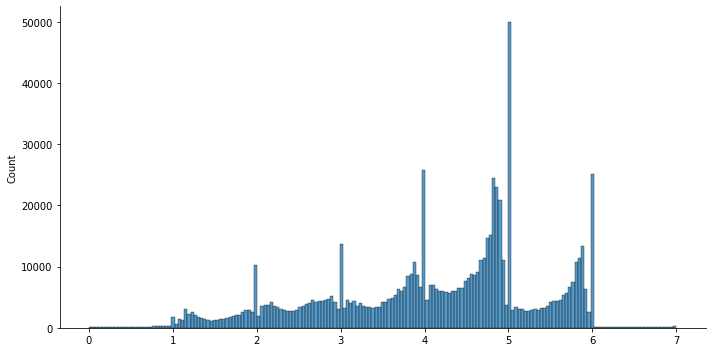

In [26]:
plt.figure()
sns.displot(data=rowwise_sum, kind='hist', height=5, aspect=2)
plt.show()

   - As can be seen from the histogram above, a large number of samples have been successfully matched (score >= 4, 475641 rows from the two datasets out of a total of 781579 rows that matched on IDs)

In [27]:
s1_lookup = s1_cstr[['source1_name_address_lookup']]
s2_lookup = s2_cstr_parsed[['source2_name_address_lookup']]

probable_matches_ = pd.merge(probable_matches, s1_lookup, left_on='Unnamed: 0', right_index=True)
probable_matches_ = pd.merge(probable_matches_, s2_lookup, left_on='Unnamed: 1', right_index=True)

#display(s1_lookup)#.iloc[1773447])
display(probable_matches_)

,index,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,city,street_number,postal_code,Score_Cos,source1_name_address_lookup,source2_name_address_lookup
0,1,1,2281460,0.902708,1.000000,1.0,0.0,1.0,0,1,4.902708,societe des sucreries du marquenterre nan rte ...,sucreries du marquenterre nan rte nationale na...
1,2,3,3012091,0.929670,1.000000,1.0,0.0,1.0,1,0,4.929670,hernas cartonnage 50.0 rue pasteur nan 80210 f...,hernas cartonnage sas 50.0 rue pasteur nan 802...
2,4,5,3200698,1.000000,0.836660,1.0,0.0,1.0,1,0,4.836660,prospa 3.0 rue du 43 ric nan 80510 longpre les...,prospa 3.0 rue 43 ric nan 80510 longpre les co...
3,5,6,3016840,0.710669,1.000000,1.0,0.0,1.0,1,0,4.710669,etablissements adrien riquier 12.0 rue henri b...,riquier adrien sa 12.0 rue henri barbusse nan ...
4,7,9,1603475,0.335083,1.000000,1.0,0.0,1.0,1,0,4.335083,cisn cooperative 13.0 av barbara nan 44570 tri...,cisn siege social trignac 13.0 av barbara nan ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
475636,781571,1773447,2599983,1.000000,0.808452,1.0,0.0,1.0,1,1,5.808452,electro force 603.0 rue de la farniere zac d e...,electro force 603.0 rue farniere nan 69400.0 g...
475637,781573,1773449,1455102,1.000000,0.790569,1.0,0.0,1.0,1,0,4.790569,entreprise jean perraud et fils 38.0 rue de li...,entreprise jean perraud et fils 38.0 rue indus...
475638,781575,1773451,1455705,0.415945,1.000000,1.0,0.0,1.0,1,0,4.415945,entreprise jean perraud et fils 19.0 av victor...,groupe perraud 19.0 av victor hugo nan 38800 l...
475639,781576,1773453,1530243,1.000000,1.000000,1.0,0.0,1.0,1,0,5.000000,bijouterie dorey freres 27.0 rue jean jaures n...,bijouterie dorey freres 27.0 rue jean jaures n...


#### Sorting entries based on Score
Sorting row matches in source1 and source2 from highest match score to lowest score, we get:

In [28]:
probable_matches_.sort_values(by=['Score_Cos', 'Unnamed: 0', 'Unnamed: 1'], ascending=False)

,index,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,city,street_number,postal_code,Score_Cos,source1_name_address_lookup,source2_name_address_lookup
430261,717321,1532404,870362,1.0,1.0,1.0,1.0,1.0,1,1,7.0,agence blue ray 33.0 rue georges bernard la pe...,agence blue ray 33.0 rue georges bernard la pe...
349885,600624,1215813,238423,1.0,1.0,1.0,1.0,1.0,1,1,7.0,skema business school 60.0 rue dostoievski cam...,skema business school 60.0 rue dostoievski cam...
278192,489569,971631,240121,1.0,1.0,1.0,1.0,1.0,1,1,7.0,ha 59.0 bd sadi carnot chez abs 6110 le cannet,ha 59.0 bd sadi carnot chez abs 6110.0 le cannet
264999,469430,926917,1401364,1.0,1.0,1.0,1.0,1.0,1,1,7.0,rhumaliance 388.0 rue georges besse parc georg...,rhumaliance 388.0 rue georges besse parc georg...
210689,384008,748797,361925,1.0,1.0,1.0,1.0,1.0,1,1,7.0,cabinet mpf 12.0 rue ferdinand buisson parc at...,cabinet mpf 12.0 rue ferdinand buisson parc at...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,251,1345,480122,1.0,1.0,1.0,0.0,1.0,0,0,4.0,sacet nan rue gustave eiffel nan 21160 marsann...,sacet 6.0 rue gustave eiffel zone industrielle...
95,191,1265,468105,1.0,0.0,1.0,0.0,1.0,1,0,4.0,ceapr 1.0 rte de troyes nan 21121 darois,ceapr 1.0 rte nan nan 21121 darois
64,139,1197,667636,1.0,1.0,1.0,0.0,1.0,0,0,4.0,piretti nan rue gustave eiffel za 21540 sombernon,piretti nan rue gustave eiffel nan 21540 sombe...
38,91,135,3157224,0.0,1.0,1.0,0.0,1.0,1,0,4.0,brunelle pressing 6.0 rue albert roze nan 8000...,clair eco 6.0 rue albert roze nan 80000 amiens


### 2.1.1.1 Some exceptional observations

1. As can be seen below, entries for ID 38990291700019 that are common to both source1 and source2 and have repeating rows with different names haven't been matched so well by `recordlinkage`. Part of the reason for such exceptions is, of course, the difference in the entries in the `name` column, but it is also majorly because of errors in parsing of the address fields by `pypostal` – `street_name` wasn't identified and parsed correctly (see section 1.2 cell 6)!

In [29]:
display(s1_cstr.loc[[426935]]) #['source2_name_address_lookup']
display(s2_cstr_parsed[s2_cstr_parsed['id'] == 38990291700019]) #['source2_name_address_lookup']
display(compared_features_id_cosine_block[compared_features_id_cosine_block['Unnamed: 1'] == 346816])
display(probable_matches_[probable_matches_['Unnamed: 1'] == 346816])

,id,name,street_number,street_type,street_name,address_line2,postal_code,city,source1_name_address_lookup
426935,38990291700019,janeli,NaN,av,de bamberg,NaN,12000,rodez,janeli nan av de bamberg nan 12000 rodez


,website,id,name,street_number,street_type,street_name,address_line2,postal_code,city,source2_name_address_lookup
346816,https://location.intermarche.com/site/,3.899029e+13,intermarche location rodez,NaN,av,NaN,NaN,12000.0,rodez,intermarche location rodez nan av nan nan 1200...
503674,https://location.intermarche.com,3.899029e+13,intermarche location rodez,NaN,av,NaN,NaN,12000,rodez,intermarche location rodez nan av nan nan 1200...
566976,http://www.intermarche.com/home.html,3.899029e+13,intermarche super,NaN,av,NaN,NaN,12000,rodez,intermarche super nan av nan nan 12000 rodez


,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,city,street_number,postal_code
226343,426935,346816,0.0,0.0,1.0,0.0,1.0,0,1


,index,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,city,street_number,postal_code,Score_Cos,source1_name_address_lookup,source2_name_address_lookup


2. Similarly, for ID 99785860000023 which is common to both source1 and source2 and has repeating rows with different names haven't been matched so well.

In [30]:
display(s1_cstr.loc[[1772837]])
display(s2_cstr_parsed[s2_cstr_parsed['id'] == 99785860000023])
display(compared_features_id_cosine_block[compared_features_id_cosine_block['Unnamed: 1'] == 2255597])
display(probable_matches_[probable_matches_['Unnamed: 1'] == 2255597])

,id,name,street_number,street_type,street_name,address_line2,postal_code,city,source1_name_address_lookup
1772837,99785860000023,societe de distribution du perche,NaN,lot,le tuilot,rte de remalard,61400,mortagne au perche,societe de distribution du perche nan lot le t...


,website,id,name,street_number,street_type,street_name,address_line2,postal_code,city,source2_name_address_lookup
2255547,http://www.intermarche.com/home.html,9.978586e+13,intermarche station service,NaN,rte,de remalard lieu dit tuilot,NaN,61400.0,mortagne au perche,intermarche station service nan rte de remalar...
2255597,NaN,9.978586e+13,intermarche,NaN,rte,de remalard lieu dit tuilot,NaN,61400.0,mortagne au perche,intermarche nan rte de remalard lieu dit tuilo...


,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,city,street_number,postal_code
781101,1772837,2255597,0.340503,0.559017,0.0,0.0,1.0,0,1


,index,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,city,street_number,postal_code,Score_Cos,source1_name_address_lookup,source2_name_address_lookup


### 2.1.1.2 Conclusion

- Even when the IDs do match exactly, the `recordlinkage` library can give us an estimate of how well the entries in the records themselves match, besides the numeric value of the IDs

### 2.1.2 Using Jaro-winkler metric with Block Indexing

Results below are from using Jaro-winkler similarity metric (developed for probabilistic record linkage problems) for string match in the two tables, with a threshold of 0.85 i.e., _if the similarity metric is above 0.85, the strings are considered to be matched (1.0) and unmatched (0.0) otherwise._

<br>

__NOTE:__

   - The Jarowinkler metric yields better results as compared to several other string similarity metrics (incl. cosine similarity), check [this](https://www.cs.cmu.edu/~wcohen/postscript/ijcai-ws-2003.pdf).
   - The cosine similarity metric does not take into account the strict ordering of words, see [here](https://medium.com/@appaloosastore/string-similarity-algorithms-compared-3f7b4d12f0ff). 
   - For the particular given datasets, other similarity metrics like the Levenshtein distance and Damerau-Levenshtein distance metrics were also tested. Results are not shown here since they were not remarkably different than the ones shown here in terms of matching accuracy.

In [2]:
compared_features_id_jw_block = pd.read_csv(os.path.join(ROOT, 'data', 'compared_features_id_block_jarowinkler_0.85.csv'))
display(compared_features_id_jw_block)

,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,city,street_number,postal_code
0,0,3201056,0.0,1.0,1.0,0.0,1.0,0,0
1,1,2281460,0.0,1.0,1.0,0.0,1.0,0,1
2,3,3012091,1.0,1.0,1.0,0.0,1.0,1,0
3,4,3026062,1.0,0.0,0.0,0.0,1.0,0,0
4,5,3200698,1.0,0.0,1.0,0.0,1.0,1,0
...,...,...,...,...,...,...,...,...,...
781574,1773450,1472477,0.0,1.0,0.0,0.0,1.0,0,0
781575,1773451,1455705,0.0,1.0,1.0,0.0,1.0,1,0
781576,1773453,1530243,1.0,1.0,1.0,0.0,1.0,1,0
781577,1773454,2024616,0.0,0.0,0.0,0.0,1.0,0,0


In [23]:
rowwise_sum_ = compared_features_id_jw_block.loc[:, 'name':'postal_code'].sum(axis=1)
#display(rowwise_sum)
rowwise_sum_[rowwise_sum_ >= 4.0]

1         4.0
2         5.0
4         4.0
5         4.0
7         4.0
         ... 
781571    5.0
781573    5.0
781575    4.0
781576    5.0
781578    4.0
Length: 452734, dtype: float64

In [31]:
probable_matches_jw = compared_features_id_jw_block[compared_features_id_jw_block.loc[:, 'name':'postal_code'].sum(axis=1) >= 4.0].reset_index()
probable_matches_jw['Score_JW'] = probable_matches_jw.loc[:, 'name':'postal_code'].sum(axis=1)
probable_matches_jw

,index,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,city,street_number,postal_code,Score_JW
0,1,1,2281460,0.0,1.0,1.0,0.0,1.0,0,1,4.0
1,2,3,3012091,1.0,1.0,1.0,0.0,1.0,1,0,5.0
2,4,5,3200698,1.0,0.0,1.0,0.0,1.0,1,0,4.0
3,5,6,3016840,0.0,1.0,1.0,0.0,1.0,1,0,4.0
4,7,9,1603475,0.0,1.0,1.0,0.0,1.0,1,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
452729,781571,1773447,2599983,1.0,0.0,1.0,0.0,1.0,1,1,5.0
452730,781573,1773449,1455102,1.0,1.0,1.0,0.0,1.0,1,0,5.0
452731,781575,1773451,1455705,0.0,1.0,1.0,0.0,1.0,1,0,4.0
452732,781576,1773453,1530243,1.0,1.0,1.0,0.0,1.0,1,0,5.0


<Figure size 432x288 with 0 Axes>

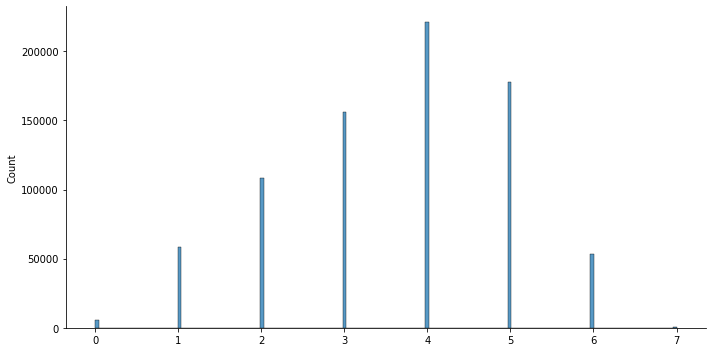

In [37]:
plt.figure()
sns.displot(data=rowwise_sum_, kind='hist', height=5, aspect=2)
plt.show()

   - As can be seen from the histogram above, 452734 rows (out of a total of 781579 rows that match on IDs) have been successfully matched (score >= 4).
   - _This number is lower than the matches performed using cosine similarity metric._

In [32]:
s1_lookup = s1_cstr[['source1_name_address_lookup']]
s2_lookup = s2_cstr_parsed[['source2_name_address_lookup']]

probable_matches_jw = pd.merge(probable_matches_jw, s1_lookup, left_on='Unnamed: 0', right_index=True)
probable_matches_jw_ = pd.merge(probable_matches_jw, s2_lookup, left_on='Unnamed: 1', right_index=True)

#display(s1_lookup)#.iloc[1773447])
display(probable_matches_jw_)

,index,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,city,street_number,postal_code,Score_JW,source1_name_address_lookup,source2_name_address_lookup
0,1,1,2281460,0.0,1.0,1.0,0.0,1.0,0,1,4.0,societe des sucreries du marquenterre nan rte ...,sucreries du marquenterre nan rte nationale na...
1,2,3,3012091,1.0,1.0,1.0,0.0,1.0,1,0,5.0,hernas cartonnage 50.0 rue pasteur nan 80210 f...,hernas cartonnage sas 50.0 rue pasteur nan 802...
2,4,5,3200698,1.0,0.0,1.0,0.0,1.0,1,0,4.0,prospa 3.0 rue du 43 ric nan 80510 longpre les...,prospa 3.0 rue 43 ric nan 80510 longpre les co...
3,5,6,3016840,0.0,1.0,1.0,0.0,1.0,1,0,4.0,etablissements adrien riquier 12.0 rue henri b...,riquier adrien sa 12.0 rue henri barbusse nan ...
4,7,9,1603475,0.0,1.0,1.0,0.0,1.0,1,0,4.0,cisn cooperative 13.0 av barbara nan 44570 tri...,cisn siege social trignac 13.0 av barbara nan ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
452729,781571,1773447,2599983,1.0,0.0,1.0,0.0,1.0,1,1,5.0,electro force 603.0 rue de la farniere zac d e...,electro force 603.0 rue farniere nan 69400.0 g...
452730,781573,1773449,1455102,1.0,1.0,1.0,0.0,1.0,1,0,5.0,entreprise jean perraud et fils 38.0 rue de li...,entreprise jean perraud et fils 38.0 rue indus...
452731,781575,1773451,1455705,0.0,1.0,1.0,0.0,1.0,1,0,4.0,entreprise jean perraud et fils 19.0 av victor...,groupe perraud 19.0 av victor hugo nan 38800 l...
452732,781576,1773453,1530243,1.0,1.0,1.0,0.0,1.0,1,0,5.0,bijouterie dorey freres 27.0 rue jean jaures n...,bijouterie dorey freres 27.0 rue jean jaures n...


In [33]:
display(probable_matches_)

,index,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,city,street_number,postal_code,Score_Cos,source1_name_address_lookup,source2_name_address_lookup
0,1,1,2281460,0.902708,1.000000,1.0,0.0,1.0,0,1,4.902708,societe des sucreries du marquenterre nan rte ...,sucreries du marquenterre nan rte nationale na...
1,2,3,3012091,0.929670,1.000000,1.0,0.0,1.0,1,0,4.929670,hernas cartonnage 50.0 rue pasteur nan 80210 f...,hernas cartonnage sas 50.0 rue pasteur nan 802...
2,4,5,3200698,1.000000,0.836660,1.0,0.0,1.0,1,0,4.836660,prospa 3.0 rue du 43 ric nan 80510 longpre les...,prospa 3.0 rue 43 ric nan 80510 longpre les co...
3,5,6,3016840,0.710669,1.000000,1.0,0.0,1.0,1,0,4.710669,etablissements adrien riquier 12.0 rue henri b...,riquier adrien sa 12.0 rue henri barbusse nan ...
4,7,9,1603475,0.335083,1.000000,1.0,0.0,1.0,1,0,4.335083,cisn cooperative 13.0 av barbara nan 44570 tri...,cisn siege social trignac 13.0 av barbara nan ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
475636,781571,1773447,2599983,1.000000,0.808452,1.0,0.0,1.0,1,1,5.808452,electro force 603.0 rue de la farniere zac d e...,electro force 603.0 rue farniere nan 69400.0 g...
475637,781573,1773449,1455102,1.000000,0.790569,1.0,0.0,1.0,1,0,4.790569,entreprise jean perraud et fils 38.0 rue de li...,entreprise jean perraud et fils 38.0 rue indus...
475638,781575,1773451,1455705,0.415945,1.000000,1.0,0.0,1.0,1,0,4.415945,entreprise jean perraud et fils 19.0 av victor...,groupe perraud 19.0 av victor hugo nan 38800 l...
475639,781576,1773453,1530243,1.000000,1.000000,1.0,0.0,1.0,1,0,5.000000,bijouterie dorey freres 27.0 rue jean jaures n...,bijouterie dorey freres 27.0 rue jean jaures n...


## 2.3 Matching rows without using exact matches on IDs

In the following, I attempt to check the performance of the `recordlinkage` library on matching rows from the two sources, but _not  assuming matching on same IDs._

Nevertheless, due to humongously huge memory and compute requirements when matching all possible pairs in the two datasets, I use blocking (matching) on `city` and sorted neighbourhood (another indexing algorithm provided by `recordlinkage`) matching on `name` to reduce the number of potential matches to a manageable amount.

String matching is performed on columns: `street_name`, `street_type`, `address_line2`; and exact matching (of numeric entries) on columns: `street_number` and `postal_code`.


<br>

__NOTE:__
- Sorted neighborhood matching on `name` will returns pairs of record that not just agree on the `name` value, but also pairs in their neighbourhood. This way some minor spelling mistakes in the `name` entries will also be taken care of.
- Perfect matches are assigned value 1.0 and non-matches (incl. unmatched NANs) have been assigned a value of 0.
- The number of rows in the tables below equal to the number of rows in the two datasets where the `city` and `name` columns have the same value plus the number of rows in the two datasets where the `name` strings are in a neighborhood of each other (decided by the value of the 'window' parameter).
- `Unnamed: 0` and `Unnamed: 1` contain indices of rows from source1 and source2, respectively.

### 2.3.1 Using Cosine metric

As can be seen below, only 421298 pairs are evaluated from the two tables.

Since there are 6 columns to match with a highest value of the cosine value being 1.0 and lowest being 0.0, the row-wise sum in the dataframe below ranges between 0.0 and 6.0.

<br>


__NOTE:__
- Matching-ID entries in the two tables where there is a NAN in any one column are automatically assigned a value of 0.0.
- I take sum values (Score) >= 4.0 as a probable match between the entries of the two sources.

In [7]:
compared_features_cosine_sorted = pd.read_csv(os.path.join(ROOT, 'data', 'compared_features_sorted_neighborhood_cosine_None.csv'))
display(compared_features_cosine_sorted)

,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,street_number,postal_code
0,3,3012091,0.929670,1.000000,1.0,0.0,1,0
1,9,1603531,0.393445,1.000000,1.0,0.0,1,0
2,31,77979,0.879049,0.852803,0.0,0.0,0,1
3,32,77979,0.879049,0.334497,0.0,0.0,0,1
4,117,1700862,0.906327,0.881917,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...
421293,1825514,546189,0.639602,0.000000,0.5,0.0,0,0
421294,1825551,189372,0.842424,0.235702,0.0,0.0,0,1
421295,1825726,1752605,0.738549,0.785714,1.0,0.0,0,0
421296,1825964,3062434,0.596285,0.000000,0.0,0.0,0,0


In [10]:
potential_matches = compared_features_cosine_sorted[compared_features_cosine_sorted.loc[:, 'name':'postal_code'].sum(axis=1) >= 4.0].reset_index()
potential_matches['Score_Cos'] = potential_matches.loc[:, 'name':'postal_code'].sum(axis=1)
potential_matches

,index,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,street_number,postal_code,Score_Cos
0,16,1442,2901262,0.906103,0.866025,0.5,0.0,1,1,4.272128
1,41,3771,127669,0.888523,0.872872,1.0,0.0,1,1,4.761395
2,45,3832,932355,0.944911,1.000000,1.0,0.0,1,1,4.944911
3,49,29284,2329574,0.559431,1.000000,1.0,0.0,1,1,4.559431
4,50,29291,2355970,0.843274,0.896421,1.0,0.0,1,1,4.739695
...,...,...,...,...,...,...,...,...,...,...
131095,421265,1820810,333787,0.874386,1.000000,1.0,0.0,1,1,4.874386
131096,421277,1822526,379751,0.835629,0.666886,1.0,0.0,1,1,4.502515
131097,421281,1823414,3425410,0.563436,0.833333,1.0,0.0,1,1,4.396770
131098,421284,1823726,843293,0.614919,1.000000,1.0,0.0,1,1,4.614919


<Figure size 432x288 with 0 Axes>

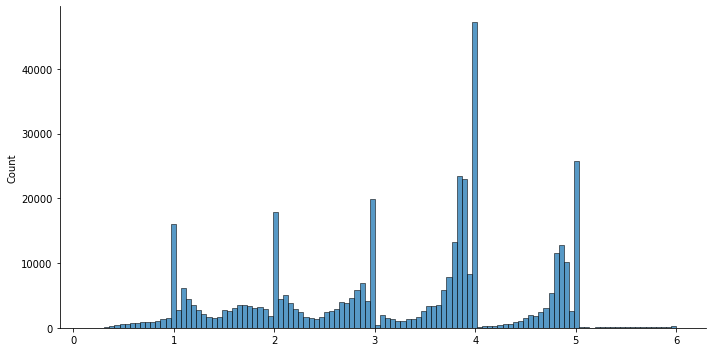

In [11]:
plt.figure()
sns.displot(data=compared_features_cosine_sorted.loc[:, 'name':'postal_code'].sum(axis=1), 
            kind='hist', height=5, aspect=2)
plt.show()

   - As can be seen from the histogram above, 131100 samples from 421298 samples have been successfully matched (score >= 4)

In [19]:
s1_lookup = s1_cstr[['source1_name_address_lookup']]
s2_lookup = s2_cstr_parsed[['source2_name_address_lookup']]

potential_matches_ = pd.merge(potential_matches, s1_lookup, left_on='Unnamed: 0', right_index=True)
potential_matches_ = pd.merge(potential_matches_, s2_lookup, left_on='Unnamed: 1', right_index=True)

#display(s1_lookup)#.iloc[1773447])
display(potential_matches_)

,index,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,street_number,postal_code,Score_Cos,source1_name_address_lookup,source2_name_address_lookup
0,16,1442,2901262,0.906103,0.866025,0.5,0.0,1,1,4.272128,leleu et fils 10.0 rte de coupigny nan 76390 i...,leleu et fils sas 10.0 rue coupigny nan 76390....
1,41,3771,127669,0.888523,0.872872,1.0,0.0,1,1,4.761395,albert vieille 629.0 rte de grasse st jean bap...,albert vieille sas 629.0 rte grasse nan 6220.0...
2,45,3832,932355,0.944911,1.000000,1.0,0.0,1,1,4.944911,revision finance cogefor 5.0 rue alfred de vig...,revision finance cogefor sa 5.0 rue alfred de ...
3,49,29284,2329574,0.559431,1.000000,1.0,0.0,1,1,4.559431,sia habitat 46.0 rue emile zola residence erne...,sia habitat le logement du travailleur 46.0 ru...
4,50,29291,2355970,0.843274,0.896421,1.0,0.0,1,1,4.739695,erisport 10.0 rue des ferronniers nan 59500 douai,erisports 10.0 rue ferronniers nan 59500.0 douai
...,...,...,...,...,...,...,...,...,...,...,...,...
131094,421257,1819978,2193496,0.602464,0.877527,1.0,0.0,1,1,4.479991,kindy lt 37.0 rue des bonnetiers nan 60220 mol...,kindy bloquert 37.0 rue bonnetiers nan 60220.0...
131095,421265,1820810,333787,0.874386,1.000000,1.0,0.0,1,1,4.874386,jour de reves events 5877.0 rte nationale 7 na...,jour de reves 5877.0 rte nationale 7 nan 13370...
131096,421277,1822526,379751,0.835629,0.666886,1.0,0.0,1,1,4.502515,golf club vezac aurillac 1.0 pl du 19 mars 196...,golf club vezac 1.0 pl dix neuf mars 1962 nan ...
131097,421281,1823414,3425410,0.563436,0.833333,1.0,0.0,1,1,4.396770,upteamiz societe de services 17.0 bd de la lib...,upteamiz 17.0 bd liberte nan 94170.0 le perreu...


### 2.3.1.1 Some observations

1. As can be seen below, entries for ID 38990291700019 that are common to both source1 and source2 and have repeating rows with different names in source2 haven't been matched at all by `recordlinkage`. This is obviously because of the entirely different entries in the `name` column.


2. A similar observation is made about the ID 99785860000023 below.

In [21]:
display(s1_cstr.loc[[426935]]) #['source2_name_address_lookup']
display(s2_cstr_parsed[s2_cstr_parsed['id'] == 38990291700019]) #['source2_name_address_lookup']
display(compared_features_cosine_sorted[compared_features_cosine_sorted['Unnamed: 1'] == 566976])
display(potential_matches[potential_matches['Unnamed: 1'] == 566976])

,id,name,street_number,street_type,street_name,address_line2,postal_code,city,source1_name_address_lookup
426935,38990291700019,janeli,NaN,av,de bamberg,NaN,12000,rodez,janeli nan av de bamberg nan 12000 rodez


,website,id,name,street_number,street_type,street_name,address_line2,postal_code,city,source2_name_address_lookup
346816,https://location.intermarche.com/site/,3.899029e+13,intermarche location rodez,NaN,av,NaN,NaN,12000.0,rodez,intermarche location rodez nan av nan nan 1200...
503674,https://location.intermarche.com,3.899029e+13,intermarche location rodez,NaN,av,NaN,NaN,12000,rodez,intermarche location rodez nan av nan nan 1200...
566976,http://www.intermarche.com/home.html,3.899029e+13,intermarche super,NaN,av,NaN,NaN,12000,rodez,intermarche super nan av nan nan 12000 rodez


,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,street_number,postal_code


,index,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,street_number,postal_code,Score_Cos


In [23]:
display(s1_cstr.loc[[1772837]])
display(s2_cstr_parsed[s2_cstr_parsed['id'] == 99785860000023])
display(compared_features_cosine_sorted[compared_features_cosine_sorted['Unnamed: 1'] == 2255597])
display(potential_matches_[potential_matches_['Unnamed: 1'] == 2255597])

,id,name,street_number,street_type,street_name,address_line2,postal_code,city,source1_name_address_lookup
1772837,99785860000023,societe de distribution du perche,NaN,lot,le tuilot,rte de remalard,61400,mortagne au perche,societe de distribution du perche nan lot le t...


,website,id,name,street_number,street_type,street_name,address_line2,postal_code,city,source2_name_address_lookup
2255547,http://www.intermarche.com/home.html,9.978586e+13,intermarche station service,NaN,rte,de remalard lieu dit tuilot,NaN,61400.0,mortagne au perche,intermarche station service nan rte de remalar...
2255597,NaN,9.978586e+13,intermarche,NaN,rte,de remalard lieu dit tuilot,NaN,61400.0,mortagne au perche,intermarche nan rte de remalard lieu dit tuilo...


,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,street_number,postal_code


,index,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,street_number,postal_code,Score_Cos,source1_name_address_lookup,source2_name_address_lookup


### 2.3.1.2 Conclusion

- It can be further analyzed how much of the IDs that are present in source1 (but not in source2) have been matched when block indexing on `city` and near-matching on the `name` columns.
- Besides, for the entries in source2 with NAN IDs, it would be interesting to see how many of those have been matched to entries in source1 with exact-matching on on `city` and near-matching on the `name` columns.



### 2.3.2 Using jaro-winkler metric

In [8]:
compared_features_jw_sorted = pd.read_csv(os.path.join(ROOT, 'data', 'compared_features_sorted_neighborhood_jarowinkler_0.85.csv'))
display(compared_features_jw_sorted)

,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,street_number,postal_code
0,3,3012091,1.0,1.0,1.0,0.0,1,0
1,9,1603531,0.0,1.0,1.0,0.0,1,0
2,31,77979,1.0,0.0,0.0,0.0,0,1
3,32,77979,1.0,0.0,0.0,0.0,0,1
4,117,1700862,1.0,1.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...
421293,1825514,546189,1.0,0.0,0.0,0.0,0,0
421294,1825551,189372,1.0,0.0,0.0,0.0,0,1
421295,1825726,1752605,1.0,1.0,1.0,0.0,0,0
421296,1825964,3062434,1.0,0.0,0.0,0.0,0,0


In [12]:
potential_matches_jw = compared_features_jw_sorted[compared_features_jw_sorted.loc[:, 'name':'postal_code'].sum(axis=1) >= 4.0].reset_index()
potential_matches_jw['Score_JW'] = potential_matches_jw.loc[:, 'name':'postal_code'].sum(axis=1)
potential_matches_jw

,index,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,street_number,postal_code,Score_JW
0,0,3,3012091,1.0,1.0,1.0,0.0,1,0,4.0
1,6,1191,481105,1.0,1.0,1.0,0.0,1,0,4.0
2,7,1194,481105,1.0,1.0,1.0,0.0,1,0,4.0
3,8,1231,625472,1.0,1.0,1.0,0.0,1,0,4.0
4,9,1246,625487,1.0,1.0,1.0,0.0,1,0,4.0
...,...,...,...,...,...,...,...,...,...,...
166090,421281,1823414,3425410,1.0,0.0,1.0,0.0,1,1,4.0
166091,421284,1823726,843293,1.0,1.0,1.0,0.0,1,1,5.0
166092,421286,1824151,433730,1.0,1.0,1.0,0.0,1,0,4.0
166093,421287,1824288,3462624,1.0,0.0,1.0,0.0,1,1,4.0


<Figure size 432x288 with 0 Axes>

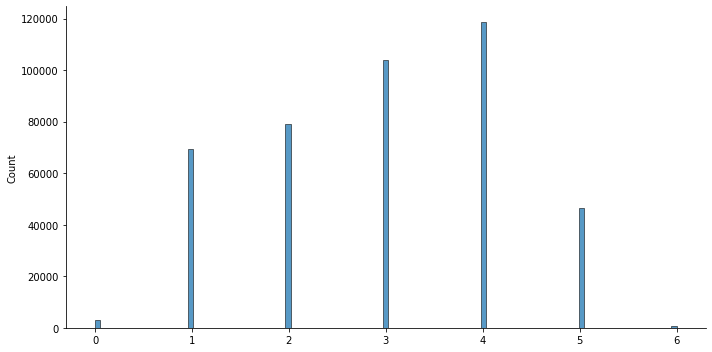

In [13]:
plt.figure()
sns.displot(data=compared_features_jw_sorted.loc[:, 'name':'postal_code'].sum(axis=1), 
            kind='hist', height=5, aspect=2)
plt.show()

   - As can be seen from above, 166095 samples from 421298 samples have been successfully matched (score >= 4)

# 3. Word2Vec based approach

This approach is mainly about assessing the problem of matching entries in the two tables based on the addresses given in them. Hence, we train a small word2vec-based model to detect matches in the addresses from 'source1' and 'source2', respectively.

_Thus, it can be considered as an address-matcher model._

__Procedure:__

1. In this approach, I am training the __word2vec model__ to generate high-dimensional embeddings ($R^{200}$) of addresses from 'source1'. 

2. The trained model is then used to extract corresponding $R^{200}$ embeddings for any given address from 'source2'.

3. This $R^{200}$ embedding of a particular address in 'source2' is then matched to its nearest neighbor embedding of addresses from 'source1' using the K-Nearest Neighbors  algorithm and the Manhattan distance.


__NOTE:__

- Due to the prohibitive requirements on memory and compute resources, I decided to run the aforementioned procedure on only matching-ID-rows from 'source1' and 'source2'. 
    - This also helps us in evaluating our final model easily, as discussed below.
    
- I did not consider matching entries on the `name` fields in the two tables since there are multiple entries in the two databases with same `name` strings but very different addresses and IDs. 
    - This would unnecessarily lead to noise in the generated embeddings of Word2Vec model.

In [28]:
from word2vec import preprocess, predict_address_matches, train
import glob

## 3.1 Training the model and generating predictions

#### Preprocessing data from rows with matching IDs

Below, we take all the columns from 'source1' and 'source2' that match on their IDs and preprocess the resulting dataframe:
   - Cleaning strings using `recordlinkage.preprocessing.clean()`
   - Combining together different address fields of 'source1' into one column `source1_address`. The NAN entries in any subfield are simply ignored. 
   - Dropping rows in 'source2' with NAN in the `address` columns

In [15]:
s1_s2_commonids = pd.read_csv(os.path.join(ROOT, 'data', 's1_s2_commonids.tsv'), sep='\t')
s1_s2_commonids

,Unnamed: 0,id,name_x,street_number,street_type,street_name,address_line2,postal_code,city,address,website,name_y
0,0,542012000015,SOCIETE DES SUCRERIES DU MARQUENTERRE,NaN,RUE,DE LA FONTAINE,NaN,80120,RUE,"1 r la Fontaine, 80120 RUE",NaN,Sucreries du Marquenterre SA
1,1,542012000031,SOCIETE DES SUCRERIES DU MARQUENTERRE,NaN,RTE,NATIONALE,NaN,62140,MARCONNELLE,"rte Nationale, 62140 MARCONNELLE",NaN,Sucreries du Marquenterre
2,2,552017600016,HERNAS CARTONNAGE,50.0,RUE,PASTEUR,NaN,80210,FEUQUIERES-EN-VIMEU,"50 r Pasteur, 80210 FEUQUIÈRES EN VIMEU",http://www.hernas.fr,Hernas Cartonnage SAS
3,3,552017600032,HERNAS CARTONNAGE,NaN,NaN,ZONE DES HAYETTES,NaN,80210,CHEPY,"zi Hayettes, 80210 CHÉPY",http://www.hernas.fr,Hernas Cartonnage
4,4,552024200016,PROSPA,3.0,RUE,DU 43 RIC,NaN,80510,LONGPRE-LES-CORPS-SAINTS,"3 r 43 Ric, 80510 LONGPRÉ LES CORPS SAINTS",http://www.prospa.fr/,Prospa
...,...,...,...,...,...,...,...,...,...,...,...,...
781300,781300,99889300200118,ENTREPRISE JEAN PERRAUD ET FILS,NaN,NaN,PEURAS,PARC D'ACTIVITE DE,38210,TULLINS,"441 av Peuras, 38210 TULLINS",http://www.groupeperraud.com,Groupe Perraud
781301,781301,99889300200142,ENTREPRISE JEAN PERRAUD ET FILS,19.0,AV,VICTOR HUGO,NaN,38800,LE PONT-DE-CLAIX,"19 av Victor Hugo, 38800 LE PONT DE CLAIX",http://www.groupeperraud.com,Groupe Perraud
781302,781302,99889340800018,BIJOUTERIE DOREY FRERES,27.0,RUE,JEAN JAURES,NaN,42420,LORETTE,"27 r Jean Jaurès, 42420 LORETTE",http://www.bijouterie-dorey.com,Bijouterie Dorey Frères
781303,781303,99891270300019,MATERIEL ELECTRIQUE LONGOVICIEN,NaN,RUE,DU PULVENTEUX,NaN,54400,LONGWY,"zi Pulventeux, 54400 LONGWY",NaN,Mel - Patiès M.E.L Matériel Electrique


In [4]:
preprocess.main() # took around 20 mins to runs on i7 8 cores

KeyboardInterrupt: 

In [99]:
s1_s2_preprocessed = pd.read_csv(os.path.join(ROOT, 'data', 'dataset', 's1_s2_commonids_preprocessed.csv'))
s1_s2_preprocessed = s1_s2_preprocessed.rename({'id': 's1s2_common_id', 
                                                'address': 'source2_address'}, axis=1)
s1_s2_preprocessed = s1_s2_preprocessed.drop(['Unnamed: 0'], axis=1)
display(s1_s2_preprocessed)

,s1s2_common_id,source2_address,source1_address
0,542012000015,1 r la fontaine 80120 rue,rue de la fontaine 80120 rue
1,542012000031,rte nationale 62140 marconnelle,rte nationale 62140 marconnelle
2,552017600016,50 r pasteur 80210 feuquieres en vimeu,50 rue pasteur 80210 feuquieres en vimeu
3,552017600032,zi hayettes 80210 chepy,zone des hayettes 80210 chepy
4,552024200016,3 r 43 ric 80510 longpre les corps saints,3 rue du 43 ric 80510 longpre les corps saints
...,...,...,...
780546,99889300200118,441 av peuras 38210 tullins,parc dactivite de peuras 38210 tullins
780547,99889300200142,19 av victor hugo 38800 le pont de claix,19 av victor hugo 38800 le pont de claix
780548,99889340800018,27 r jean jaures 42420 lorette,27 rue jean jaures 42420 lorette
780549,99891270300019,zi pulventeux 54400 longwy,rue du pulventeux 54400 longwy


In [102]:
len(np.unique(s1_s2_preprocessed['s1s2_common_id']))

780130

#### Training the model 

![model_train.png](model_train.png)

In [3]:
train.main() # took around 3 hr to runs on i7 8 cores

Writing new pickle file... /home/thabib/database_records_linkage/data/trained_data/knn_1.pickle


#### Prediction of source1-nearest-neighbors of 'source2' addresses and attaching their corresponding 'source1' IDs

![model_prediction.png](model_prediction.png)

In [3]:
predict_address_matches.main() # took around 20 hrs to runs on i7 8 cores

2022-04-14 15:57:15,115 : INFO : loading Word2Vec object from /home/thabib/database_records_linkage/data/trained_data/source1_model.model
2022-04-14 15:57:15,179 : INFO : loading wv recursively from /home/thabib/database_records_linkage/data/trained_data/source1_model.model.wv.* with mmap=None
2022-04-14 15:57:15,181 : INFO : loading vectors from /home/thabib/database_records_linkage/data/trained_data/source1_model.model.wv.vectors.npy with mmap=None
2022-04-14 15:57:15,238 : INFO : loading syn1neg from /home/thabib/database_records_linkage/data/trained_data/source1_model.model.syn1neg.npy with mmap=None
2022-04-14 15:57:15,286 : INFO : setting ignored attribute cum_table to None
2022-04-14 15:57:16,260 : INFO : Word2Vec lifecycle event {'fname': '/home/thabib/database_records_linkage/data/trained_data/source1_model.model', 'datetime': '2022-04-14T15:57:16.260460', 'gensim': '4.1.2', 'python': '3.8.12 (default, Oct 12 2021, 13:49:34) \n[GCC 7.5.0]', 'platform': 'Linux-5.13.0-39-generic

Loading from existing pickle file... /home/thabib/database_records_linkage/data/trained_data/knn_1.pickle


Pandas Apply:   0%|          | 0/21681 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [103]:
predicted_s2address_ids = pd.read_csv(os.path.join(ROOT, 'data', 'dataset', 'final_output', 'all_source2_address_ids.csv'))
predicted_s2address_ids = predicted_s2address_ids.rename({'id': 'source1_predicted_id',
                                                          'address': 'source2_address'}, axis=1)
display(predicted_s2address_ids)

,source2_address,source1_predicted_id
0,1 r la fontaine 80120 rue,542012000015
1,rte nationale 62140 marconnelle,542012000031
2,50 r pasteur 80210 feuquieres en vimeu,552017600016
3,zi hayettes 80210 chepy,552017600032
4,3 r 43 ric 80510 longpre les corps saints,552024200016
...,...,...
780546,parc de la lauze 70 r helene boucher 34430 sai...,49245241200017
780547,44 r orgeval 77120 coulommiers,33678030900165
780548,109 av louis gallouedec 45400 fleury les aubrais,32902163800203
780549,5 all alouettes 95800 courdimanche,82862000500011


In [104]:
len(np.unique(predicted_s2address_ids['source1_predicted_id']))

508814

## 3.2 Results

### 3.2.1 Matching on same IDs and evaluating the corresponding closeness of the two addresses

1. In the table `merged_on_ids` below, all the source2 addresses are matched with their corresponding source1 addresses, where the matching is made on model-predicted IDs, generated from `predicted_s2address_ids` above.

In [109]:
merged_on_ids = pd.merge(predicted_s2address_ids, s1_s2_preprocessed, 
                         left_on='source1_predicted_id', right_on='s1s2_common_id', how='inner')
merged_on_ids = merged_on_ids.rename({'id': 'source1_predicted_id', 
                                      'source2_address_x': 'source2_address'}, axis=1)
#merged_on_ids = merged_on_ids.drop(['source2_address_y'], axis=1)
display(merged_on_ids)

,source2_address,source1_predicted_id,s1s2_common_id,source2_address_y,source1_address
0,1 r la fontaine 80120 rue,542012000015,542012000015,1 r la fontaine 80120 rue,rue de la fontaine 80120 rue
1,rte nationale 62140 marconnelle,542012000031,542012000031,rte nationale 62140 marconnelle,rte nationale 62140 marconnelle
2,rte nationale 62140 marconnelle,542012000031,542012000031,rte nationale 62140 marconnelle,rte nationale 62140 marconnelle
3,rte nationale 62140 marconnelle,542012000031,542012000031,rte nationale 62140 marconnelle,rte nationale 62140 marconnelle
4,rte nationale 62140 marconnelle,542012000031,542012000031,rte nationale 62140 marconnelle,rte nationale 62140 marconnelle
...,...,...,...,...,...
781232,la lande du camp 72230 ruaudin,53373501500034,53373501500034,lieu dit la lande du camp 44 bd hunaudieres 72...,la lande du camp 72230 ruaudin
781233,29 pl emile bollaert 59140 dunkerque,82861618500017,82861618500017,29 pl emile bollaert 59140 dunkerque,29 pl emile bollaert 59140 dunkerque
781234,2 r ligier 33000 bordeaux,82861697900021,82861697900021,2 r ligier 33000 bordeaux,2 rue ligier 33000 bordeaux
781235,7 pl portail 48130 aumont aubrac,82861774600015,82861774600015,7 pl portail 48130 aumont aubrac,7 pl du portail 48130 peyre en aubrac


In [110]:
unique_id_merged = np.unique(merged_on_ids['source1_predicted_id'])
unique_id_merged

array([  542012000015,   542012000031,   552017600016, ...,
       99889300200092, 99889300200118, 99889340800018])

2. We now evaluate the cosine similarity of the two addresses – `source1_address` and `source2_address` – in `merged_on_ids` which match on (predicted) unique IDs.

In [84]:
from word2vec.modeling import word_2_vec
model = word_2_vec.load_w2v(os.path.join(ROOT, 'data', 'trained_data', 'source1_model.model'))

similarity_ = []
for id_ in unique_id_merged:
    source2_address_vec = word_2_vec.get_vector(model, merged_on_ids[merged_on_ids['source1_predicted_id'] == id_].iloc[0]['source2_address'])
    source1_address_vec = word_2_vec.get_vector(model, merged_on_ids[merged_on_ids['source1_predicted_id'] == id_].iloc[0]['source1_address'])
    similarity_.append(word_2_vec.similarity(source2_address_vec, source1_address_vec))

2022-04-14 19:04:25,765 : INFO : loading Word2Vec object from /home/thabib/database_records_linkage/data/trained_data/source1_model.model
2022-04-14 19:04:25,798 : INFO : loading wv recursively from /home/thabib/database_records_linkage/data/trained_data/source1_model.model.wv.* with mmap=None
2022-04-14 19:04:25,798 : INFO : loading vectors from /home/thabib/database_records_linkage/data/trained_data/source1_model.model.wv.vectors.npy with mmap=None
2022-04-14 19:04:25,831 : INFO : loading syn1neg from /home/thabib/database_records_linkage/data/trained_data/source1_model.model.syn1neg.npy with mmap=None
2022-04-14 19:04:25,900 : INFO : setting ignored attribute cum_table to None
2022-04-14 19:04:26,911 : INFO : Word2Vec lifecycle event {'fname': '/home/thabib/database_records_linkage/data/trained_data/source1_model.model', 'datetime': '2022-04-14T19:04:26.911953', 'gensim': '4.1.2', 'python': '3.8.12 (default, Oct 12 2021, 13:49:34) \n[GCC 7.5.0]', 'platform': 'Linux-5.13.0-39-generic

In [96]:
cosine_similarity = np.array(similarity_)
matching = cosine_similarity[cosine_similarity > 0.8]

percent_matched_entries = (len(matching)/len(unique_id_merged))*100
print('Percentage of addresses that match between source1 and source2 with cosine similarity of 0.8 and above: {}'.format(percent_matched_entries))

Percentage of addresses that match between source1 and source2 with cosine similarity of 0.8 and above: 99.12522061106809


### 3.2.1.1 Observations

1. Out of the total 780551 addresses in 'source2', 271737 addresses have been assigned to the same IDs (i.e. "neighbouring" addresses in source1) in source1.

2. Almost all of the addresses in 'source2', that have a matching ID in 'source1', match their counterparts in 'source1'. This shouldn't be a surprizing result if we assume the datasets do not have a lot of mistakes and are  well-maintained.

3. The model above can also be used to match entries (based on address) in the two databases where there is a missing ID in one of the tables.

### 3.2.2 Matching on same addresses (from source2) and evaluating the corresponding matches on IDs and closeness with addresses in source1

In [118]:
merged_on_address = pd.merge(predicted_s2address_ids, s1_s2_preprocessed, on='source2_address')
#merged_on_address = merged_on_address.rename({'id_x': 'source1_predicted_id', 
 #                                             'id_y': 'common_ids'}, axis=1)
#merged_on_address = merged_on_ids.drop(['Unnamed: 0'], axis=1)
display(merged_on_address)

,source2_address,source1_predicted_id,s1s2_common_id,source1_address
0,1 r la fontaine 80120 rue,542012000015,542012000015,rue de la fontaine 80120 rue
1,rte nationale 62140 marconnelle,542012000031,542012000031,rte nationale 62140 marconnelle
2,rte nationale 62140 marconnelle,542012000031,34163372500906,route nationale 62140 marconnelle
3,rte nationale 62140 marconnelle,542012000031,44028375201760,rn39 rn 39 62140 marconnelle
4,rte nationale 62140 marconnelle,542012000031,80857361200021,rte nationale 62140 marconnelle
...,...,...,...,...
1161214,7 pl portail 48130 aumont aubrac,82861774600015,82861774600015,7 pl du portail 48130 peyre en aubrac
1161215,parc de la lauze 70 r helene boucher 34430 sai...,49245241200017,82861934600012,70 rue helene boucher 34430 saint jean de vedas
1161216,44 r orgeval 77120 coulommiers,33678030900165,82861957700012,zac de la prairie saint pierre 44 rue de l org...
1161217,5 all alouettes 95800 courdimanche,82862000500011,82862000500011,5 all des alouettes 95800 courdimanche


### 3.2.2.1 Observations

- Not surprisgly, the "address-matcher" model confuses between 4 distinct entries in source1 and source2 that have the same addresses (rte nationale 62140 marconnelle, see rows 1,2,3,4 above). The model, therefore, needs to be further refined on learning to match on the `name` fields also.

In [127]:
display(s1_cstr[s1_cstr['id'] == 542012000031])
display(s1_cstr[s1_cstr['id'] == 34163372500906])
display(s1_cstr[s1_cstr['id'] == 44028375201760])
display(s1_cstr[s1_cstr['id'] == 80857361200021])

,id,name,street_number,street_type,street_name,address_line2,postal_code,city
1,542012000031,societe des sucreries du marquenterre,NaN,rte,nationale,NaN,62140,marconnelle


,id,name,street_number,street_type,street_name,address_line2,postal_code,city
297805,34163372500906,vertdis,NaN,NaN,route nationale,NaN,62140,marconnelle


,id,name,street_number,street_type,street_name,address_line2,postal_code,city
664575,44028375201760,csf,NaN,NaN,rn 39,rn39,62140,marconnelle


,id,name,street_number,street_type,street_name,address_line2,postal_code,city
1362755,80857361200021,ssm opale,NaN,rte,nationale,NaN,62140,marconnelle


In [128]:
display(s2_nond_cstr[s2_nond_cstr['id'] == 542012000031])
display(s2_nond_cstr[s2_nond_cstr['id'] == 34163372500906])
display(s2_nond_cstr[s2_nond_cstr['id'] == 44028375201760])
display(s2_nond_cstr[s2_nond_cstr['id'] == 80857361200021])

,address,website,id,name
2281460,rte nationale 62140 marconnelle,NaN,542012000031,sucreries du marquenterre


,address,website,id,name
2281432,rte nationale 62140 marconnelle,https://www.magasin-prisedirect.fr/magasin/mar...,34163372500906,gamm vert


,address,website,id,name
2281428,rte nationale 62140 marconnelle,http://www.carrefour.fr/magasin/market-hesdin,44028375201760,carrefour market


,address,website,id,name
2281459,rte nationale 62140 marconnelle,http://www.hotel-le-semaphore.com,80857361200021,ssm opale


- The model correctly matches entries on addresses which have different `name` strings, as seen below:

In [136]:
display(s1_s2_preprocessed[s1_s2_preprocessed['s1s2_common_id'] == 41817353000035])
#display(s1_s2_preprocessed[s1_s2_preprocessed['s1s2_common_id'] == 82862005400019])

display(s1_cstr[s1_cstr['id'] == 41817353000035])
display(s2_nond_cstr[s2_nond_cstr['id'] == 41817353000035])

#display(s1_cstr[s1_cstr['id'] == 82862005400019])
#display(s2_nond_cstr[s2_nond_cstr['id'] == 82862005400019])

,s1s2_common_id,source2_address,source1_address
291439,41817353000035,30 r st michel 14000 caen,30 rue saint michel 14000 caen


,id,name,street_number,street_type,street_name,address_line2,postal_code,city
558671,41817353000035,mouvement francais planning familial,30.0,rue,saint michel,NaN,14000,caen


,address,website,id,name
624167,30 r st michel 14000 caen,http://www.planning-familial.org,41817353000035,planning familial association departementale d...


In [134]:
not_in_s1_s2 = list(set(s1_s2_preprocessed['s1s2_common_id']).difference(unique_id_merged))
len(not_in_s1_s2)

271316

#### Please Note:

- I have tried some other fuzzy matching techniques also, which could be seen in 1_attempt.ipynb file.

# ROUGH

In [23]:
compared_features_id_jw_sorted = pd.read_csv(os.path.join(ROOT, 'data', 'compared_features_id_sorted_neighborhood_jarowinkler_0.85.csv'))
display(compared_features_id_jw_sorted)

,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,city,street_number,postal_code
0,3,3012091,1.0,1.0,1.0,-1.0,1.0,1,0
1,31,77979,1.0,0.0,-1.0,-1.0,1.0,-1,1
2,117,1700862,1.0,1.0,-1.0,-1.0,1.0,-1,0
3,131,674840,1.0,-1.0,-1.0,-1.0,1.0,-1,0
4,1191,481105,1.0,1.0,1.0,-1.0,1.0,1,0
...,...,...,...,...,...,...,...,...,...
337763,1772882,2947865,1.0,0.0,-1.0,-1.0,1.0,-1,1
337764,1772883,2405821,1.0,1.0,1.0,-1.0,1.0,-1,1
337765,1772896,2747684,1.0,0.0,1.0,-1.0,1.0,1,0
337766,1772912,257879,1.0,0.0,1.0,-1.0,1.0,1,1


### Cosine metric with Sorted Neighborhood Indexing

- Perfect matches are assigned value 1.0 and non-matches (incl. unmatched NANs) have been assigned a value of 0.
- The number of rows in the tables below equal to the number of rows in the two datasets where the `id` column has the same value.

In [24]:
compared_features_id_cosine_sorted = pd.read_csv(os.path.join(ROOT, 'data', 'compared_features_id_sorted_neighborhood_cosine_None.csv'))
display(compared_features_id_cosine_sorted)

,Unnamed: 0,Unnamed: 1,name,street_name,street_type,address_line2,city,street_number,postal_code
0,3,3012091,0.929670,1.000000,1.0,0.0,1.000000,1,0
1,31,77979,0.879049,0.852803,0.0,0.0,1.000000,0,1
2,117,1700862,0.906327,0.881917,0.0,0.0,1.000000,0,0
3,131,674840,0.938083,0.000000,0.0,0.0,1.000000,0,0
4,1191,481105,0.956183,1.000000,1.0,0.0,1.000000,1,0
...,...,...,...,...,...,...,...,...,...
337763,1772882,2947865,0.830540,0.204124,0.0,0.0,1.000000,0,1
337764,1772883,2405821,0.832050,1.000000,1.0,0.0,1.000000,0,1
337765,1772896,2747684,0.794719,0.852803,1.0,0.0,0.707107,1,0
337766,1772912,257879,0.891133,0.833333,1.0,0.0,1.000000,1,1


In [26]:
rowwise_sum_sorted = compared_features_id_cosine_sorted.loc[:, 'name':'postal_code'].sum(axis=1)
#display(rowwise_sum)
rowwise_sum_sorted[rowwise_sum_sorted > 4.0]

0         4.929670
4         4.956183
5         4.894427
6         4.804535
7         4.828266
            ...   
337757    4.599609
337764    4.832050
337765    4.354629
337766    5.724466
337767    4.880771
Length: 224005, dtype: float64

<Figure size 432x288 with 0 Axes>

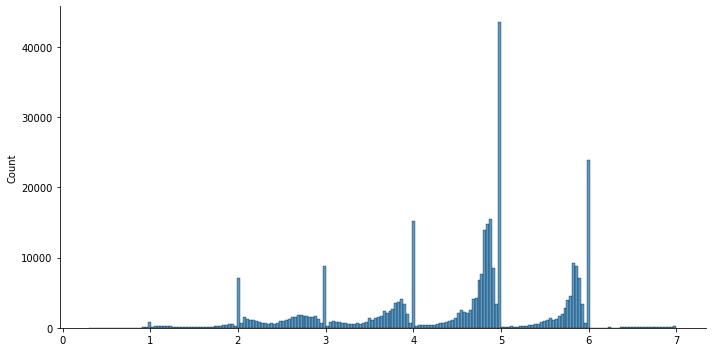

In [27]:
plt.figure()
sns.displot(data=rowwise_sum_sorted, kind='hist', height=5, aspect=2)
plt.show()

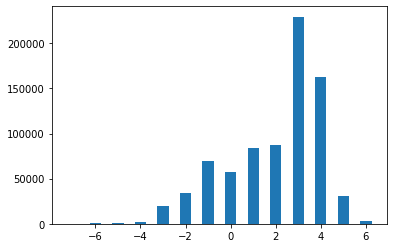

In [35]:
plt.figure()
y, binEdges = np.histogram(compared_features_id_cosine_block.loc[:, 'name':'postal_code'].sum(axis=1), 
                           bins=np.arange(-7,8))
plt.bar(binEdges[:-1], y, width=0.5)
#plt.hist(compared_features_id_cosine_block.loc[:, 'name':'postal_code'].sum(axis=1))
plt.show()